# DQN (2013) 训练 Notebook

本 Notebook 用于训练 DQN 智能体玩 Video Pinball 游戏。

**特性：**
- 实时显示训练进度
- 定期保存检查点
- 强制使用 CUDA

## 0.导入到Google Colab

In [ ]:
# 挂载 Google Drive 保存检查点
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Code/BIT-Embodied-Project
import os, sys
sys.path.insert(0, os.getcwd())

## 1. 环境检查

In [1]:
import sys
import os
import torch

# 检查 CUDA
if not torch.cuda.is_available():
    raise RuntimeError("CUDA 不可用！请确保已安装 CUDA 版本的 PyTorch。")

# 启用 TF32 加速
torch.set_float32_matmul_precision('high')

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU 内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
PyTorch: 2.9.1+cu128
CUDA: 12.8
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU 内存: 8.3 GB


## 2. 导入依赖

In [2]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
import time
import imageio

# 添加项目路径
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

from envs import VideoPinballEnv
from envs.wrappers import FrameStack, ClipRewardEnv
from dqn import DQNAgent, Transition

## 3. 训练配置

In [3]:
# 训练参数
CONFIG = {
    'total_frames': 10_000_000,     # 总训练帧数
    'log_interval': 10_000,          # 日志输出间隔
    'plot_interval': 50_000,         # 绘图更新间隔
    'eval_interval': 100_000,        # 评估间隔
    'save_interval': 500_000,        # 保存间隔
    'save_dir': 'checkpoints',       # 保存目录
}

print("训练配置:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

训练配置:
  total_frames: 10000000
  log_interval: 10000
  plot_interval: 50000
  eval_interval: 100000
  save_interval: 500000
  save_dir: checkpoints


## 4. 初始化环境和智能体

In [4]:
# 创建环境
env = VideoPinballEnv()
env = ClipRewardEnv(env)
env = FrameStack(env, num_stack=4)

n_actions = env.get_action_space()
print(f"动作空间: {n_actions}")

# 创建智能体（强制 CUDA）
agent = DQNAgent(n_actions=n_actions, device='cuda', use_compile=False)
print(f"设备: {agent.device}")

# 创建保存目录
os.makedirs(CONFIG['save_dir'], exist_ok=True)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


动作空间: 9
设备: cuda


## 5. 训练循环（带可视化）

In [5]:
def plot_progress(episode_rewards, losses, frame):
    """Plot training progress"""
    clear_output(wait=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Reward curve
    ax1 = axes[0]
    if len(episode_rewards) > 0:
        ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Episode')
        # Moving average
        if len(episode_rewards) >= 100:
            window = 100
            avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(episode_rewards)), avg, color='red', label=f'{window}-ep avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Training Progress - Frame: {frame:,}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss curve
    ax2 = axes[1]
    if len(losses) > 0:
        ax2.plot(losses, alpha=0.5, color='green')
    ax2.set_xlabel('Update Steps')
    ax2.set_ylabel('Loss')
    ax2.set_title('TD Loss')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

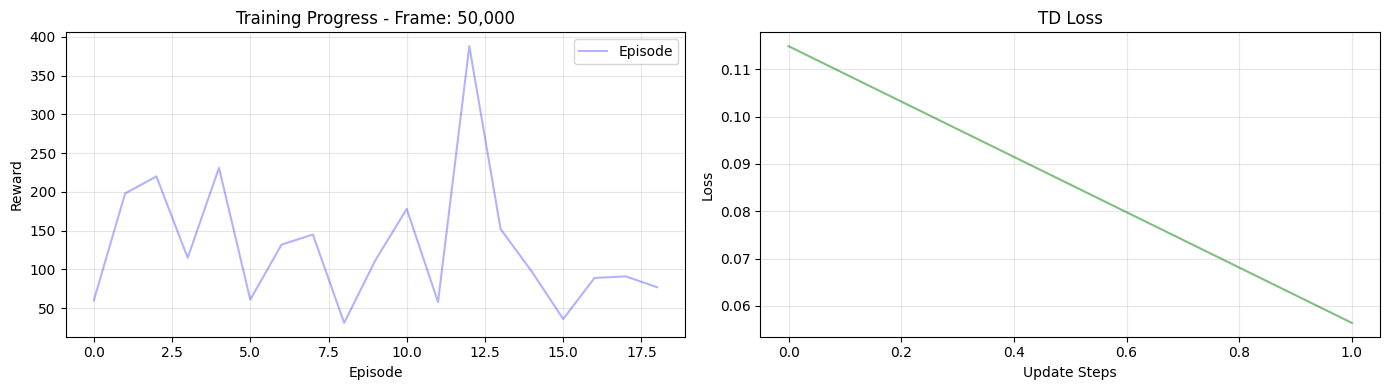

帧: 50,000 | 回合: 19 | 平均奖励(100): 130.05 | epsilon: 0.955 | FPS: 2092


KeyboardInterrupt: 

In [6]:
# 统计数据
episode_rewards = []
losses = []
episode_reward = 0
episode_count = 0
state = env.reset()
start_time = time.time()

print("开始训练...")

# 主循环
for frame in range(1, CONFIG['total_frames'] + 1):
    agent.frame_count = frame
    
    # 选择动作
    action = agent.select_action(state)
    
    # 执行动作
    next_state, reward, done, info = env.step(action)
    episode_reward += reward
    
    # 存储经验
    agent.store_transition(Transition(state, action, reward, next_state, done))
    
    # 训练更新
    loss = agent.update()
    if loss is not None:
        losses.append(loss)
    
    state = next_state
    
    # 回合结束
    if done:
        episode_rewards.append(episode_reward)
        episode_count += 1
        episode_reward = 0
        state = env.reset()
    
    # 绘图更新
    if frame % CONFIG['plot_interval'] == 0:
        elapsed = time.time() - start_time
        fps = frame / elapsed
        plot_progress(episode_rewards, losses[-1000:], frame)
        print(f"帧: {frame:,} | 回合: {episode_count} | "
              f"平均奖励(100): {np.mean(episode_rewards[-100:]) if episode_rewards else 0:.2f} | "
              f"epsilon: {agent.get_epsilon():.3f} | "
              f"FPS: {fps:.0f}")
    
    # 保存检查点
    if frame % CONFIG['save_interval'] == 0:
        save_path = os.path.join(CONFIG['save_dir'], f'dqn_frame_{frame}.pt')
        agent.save(save_path)

# 保存最终模型
final_path = os.path.join(CONFIG['save_dir'], 'dqn_final.pt')
agent.save(final_path)

env.close()
print("\n训练完成！")

## 6. 查看最终结果

In [6]:
# 最终训练曲线
plot_progress(episode_rewards, losses[-1000:], CONFIG['total_frames'])

print(f"\n训练统计:")
print(f"  总回合数: {len(episode_rewards)}")
print(f"  最高奖励: {max(episode_rewards) if episode_rewards else 0:.2f}")
print(f"  最终 100 回合平均: {np.mean(episode_rewards[-100:]) if episode_rewards else 0:.2f}")

NameError: name 'episode_rewards' is not defined

## 7. 评估训练好的智能体

In [9]:
def evaluate(agent, n_episodes=10, save_video=True, video_dir='videos'):
    """评估智能体，可选保存视频"""
    eval_env = VideoPinballEnv(render_mode='rgb_array' if save_video else None)
    eval_env = ClipRewardEnv(eval_env)
    eval_env = FrameStack(eval_env, num_stack=4)
    
    if save_video:
        os.makedirs(video_dir, exist_ok=True)
    
    rewards = []
    for ep in range(n_episodes):
        state = eval_env.reset()
        total = 0
        done = False
        frames = []
        
        while not done:
            if save_video:
                frames.append(eval_env.unwrapped.ale.getScreenRGB())
            
            action = agent.select_action(state, eval_mode=True)
            state, reward, done, _ = eval_env.step(action)
            total += reward
        
        rewards.append(total)
        print(f"  回合 {ep+1}: {total:.2f}")
        
        if save_video and frames:
            video_path = os.path.join(video_dir, f'episode_{ep+1}.mp4')
            imageio.mimsave(video_path, frames, fps=30, macro_block_size=1)
            print(f"    视频已保存: {video_path}")
    
    eval_env.close()
    return np.mean(rewards), np.std(rewards)

print("评估中...")
mean_reward, std_reward = evaluate(agent, n_episodes=10, save_video=True)
print(f"\n评估结果: {mean_reward:.2f} ± {std_reward:.2f}")

评估中...


KeyboardInterrupt: 